In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import copy

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set to {SEED}.")

Random seed set to 42.


In [3]:
EPOCHS = 200
BATCH_SIZE = 32
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

print(f"Data loaded. Features shape: {X.shape}, Target shape: {y.shape}")
print(f"Number of features: {diabetes.feature_names}")

Data loaded. Features shape: (442, 10), Target shape: (442,)
Number of features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=SEED
)

print(f"Data split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Data split complete.
Training samples: 353
Testing samples: 89


In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Reshape y to [n_samples, 1]
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("Data converted to PyTorch tensors.")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

Data converted to PyTorch tensors.
X_train_tensor shape: torch.Size([353, 10])
y_train_tensor shape: torch.Size([353, 1])


In [8]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}.")

DataLoaders created with batch size 32.


In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        # 10 input features, 1 output
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Get input dimension from the data
input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)

print("Model architecture:")
print(model)

Model architecture:
LinearRegressionModel(
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [10]:
model = LinearRegressionModel(input_dim).to(device)

# Loss function: Mean Squared Error (MSE) for regression
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Model, Loss Function (MSELoss), and Optimizer (Adam) initialized.")
print(f"Model moved to {device}.")

Model, Loss Function (MSELoss), and Optimizer (Adam) initialized.
Model moved to cpu.


In [11]:
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_weights = None

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass
        outputs = model(inputs)

        # 3. Calculate loss
        loss = criterion(outputs, labels)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * inputs.size(0)

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Save the best model
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        best_model_weights = copy.deepcopy(model.state_dict())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss (MSE): {epoch_train_loss:.4f} | Test Loss (MSE): {epoch_test_loss:.4f}")

print("Training finished.")

# Load the best model weights
model.load_state_dict(best_model_weights)
print(f"Best model weights loaded (Test MSE: {best_test_loss:.4f})")

Starting training for 200 epochs...
Epoch 20/200 | Train Loss (MSE): 29570.7222 | Test Loss (MSE): 26437.2709
Epoch 40/200 | Train Loss (MSE): 29422.9576 | Test Loss (MSE): 26334.4030
Epoch 60/200 | Train Loss (MSE): 29276.0400 | Test Loss (MSE): 26230.9051
Epoch 80/200 | Train Loss (MSE): 29138.0870 | Test Loss (MSE): 26132.5279
Epoch 100/200 | Train Loss (MSE): 29003.3156 | Test Loss (MSE): 26037.4885
Epoch 120/200 | Train Loss (MSE): 28866.1415 | Test Loss (MSE): 25940.9653
Epoch 140/200 | Train Loss (MSE): 28727.8794 | Test Loss (MSE): 25843.9307
Epoch 160/200 | Train Loss (MSE): 28600.7744 | Test Loss (MSE): 25755.3015
Epoch 180/200 | Train Loss (MSE): 28469.8397 | Test Loss (MSE): 25666.1945
Epoch 200/200 | Train Loss (MSE): 28340.2128 | Test Loss (MSE): 25576.0961
Training finished.
Best model weights loaded (Test MSE: 25576.0961)


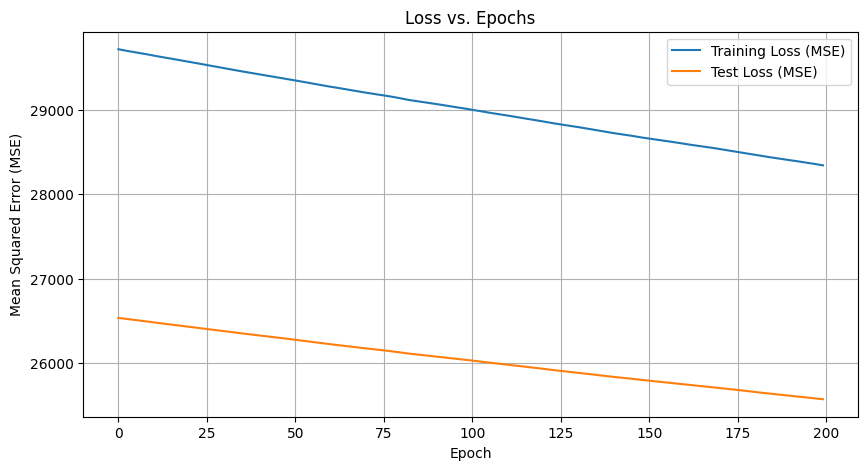

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss (MSE)')
plt.plot(test_losses, label='Test Loss (MSE)')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()


Final Model Evaluation on Test Set:
Mean Squared Error (MSE): 25576.0957
R-squared (R²): -3.8274


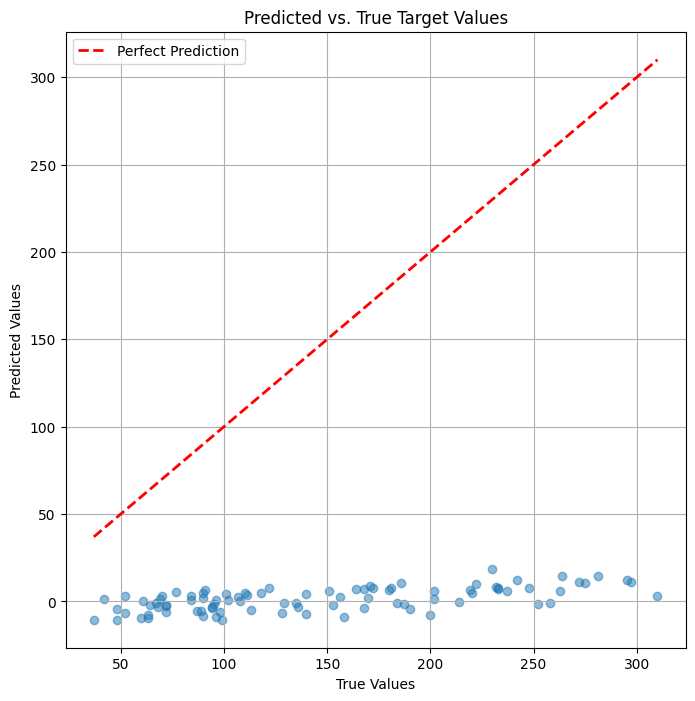

In [13]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists of arrays to single numpy arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Calculate final metrics
final_mse = mean_squared_error(all_labels, all_preds)
final_r2 = r2_score(all_labels, all_preds)

print(f"\nFinal Model Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {final_mse:.4f}")
print(f"R-squared (R²): {final_r2:.4f}")

# Plot: Predicted vs. True
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.5)
# Add a line for perfect predictions
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.title('Predicted vs. True Target Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
MODEL_PATH = 'diabetes_regression_model.pth'
torch.save(model.state_dict(), MODEL_PATH)

print(f"\nModel state dictionary saved to {MODEL_PATH}")


Model state dictionary saved to diabetes_regression_model.pth
